<a href="https://colab.research.google.com/github/tmutengwa/-Capestone-Project_Image-classification_TV-Script-Generation/blob/master/Homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-21 12:11:26--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.009s  

2025-10-21 12:11:26 (8.39 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('course_lead_scoring.csv')

# Check for missing values
print("Missing values before handling:")
print(df.isnull().sum())

# Handle missing values
for col in df.columns:
    if df[col].dtype == 'object':  # Categorical features
        df[col] = df[col].fillna('NA')
    else:  # Numerical features
        df[col] = df[col].fillna(0.0)

print("\nMissing values after handling:")
print(df.isnull().sum())

# Split the data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1) # 0.25 * 0.8 = 0.2

print(f"\nTraining set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Missing values before handling:
lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

Missing values after handling:
lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

Training set size: 876
Validation set size: 293
Test set size: 293


In [ ]:
from sklearn.metrics import roc_auc_score

numerical = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
target = 'converted'

auc_scores = {}

for col in numerical:
    auc = roc_auc_score(df_train[target], df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(df_train[target], -df_train[col])
    auc_scores[col] = auc

print("AUC scores for numerical variables:")
for col, auc in auc_scores.items():
    print(f"{col}: {auc:.4f}")

highest_auc_feature = max(auc_scores, key=auc_scores.get)
print(f"\nNumerical variable with the highest AUC: {highest_auc_feature}")

AUC scores for numerical variables:
lead_score: 0.6145
number_of_courses_viewed: 0.7636
interaction_count: 0.7383
annual_income: 0.5520

Numerical variable with the highest AUC: number_of_courses_viewed


In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

categorical = ['lead_source', 'industry', 'employment_status', 'location']

# Prepare data for DictVectorizer
train_dict = df_train[categorical + numerical].to_dict(orient='records')
val_dict = df_val[categorical + numerical].to_dict(orient='records')

# Apply DictVectorizer
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Train Logistic Regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, df_train[target])

# Predict on validation set
y_pred_val = model.predict_proba(X_val)[:, 1]

# Calculate AUC on validation set
auc_val = roc_auc_score(df_val[target], y_pred_val)

print(f"AUC on validation dataset: {auc_val:.3f}")

AUC on validation dataset: 0.817


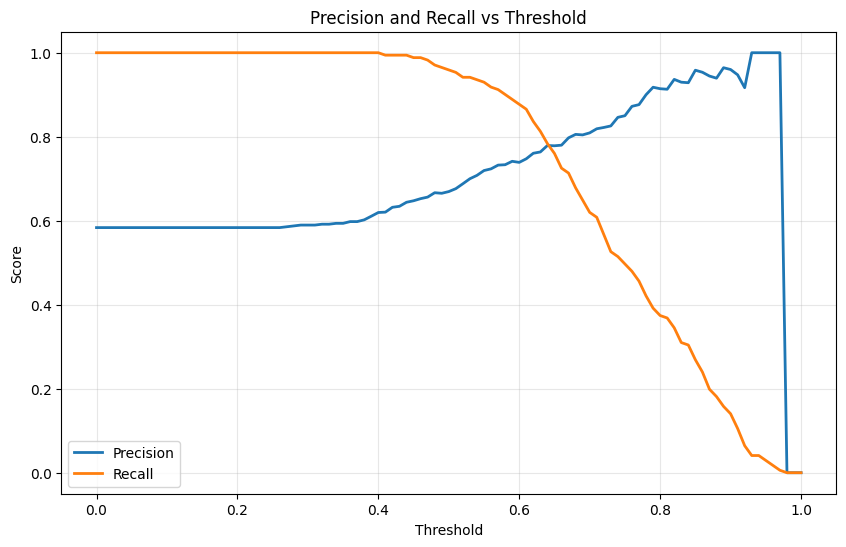


Precision and Recall curves intersect at threshold: 0.980
Precision at intersection: 0.000
Recall at intersection: 0.000


In [ ]:
# Calculate precision and recall for different thresholds
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for threshold in thresholds:
    y_pred_binary = (y_pred_val >= threshold).astype(int)

    # Calculate precision and recall
    tp = np.sum((y_pred_binary == 1) & (df_val[target] == 1))
    fp = np.sum((y_pred_binary == 1) & (df_val[target] == 0))
    fn = np.sum((y_pred_binary == 0) & (df_val[target] == 1))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    precisions.append(precision)
    recalls.append(recall)

# Plot precision and recall curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find intersection points
differences = np.array(precisions) - np.array(recalls)
intersection_thresholds = []
for i in range(1, len(thresholds)):
    # Check for sign change or near-zero difference
    if (differences[i-1] * differences[i] <= 0) or (abs(differences[i]) < 0.001):
        intersection_thresholds.append(thresholds[i])

print(f"\nPotential intersection thresholds:")
for threshold in intersection_thresholds:
    print(f"{threshold:.3f}")

In [ ]:
# Calculate F1 score for all thresholds
f1_scores = []
for i in range(len(thresholds)):
    p = precisions[i]
    r = recalls[i]
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    f1_scores.append(f1)

# Find the threshold with the maximal F1 score
max_f1 = max(f1_scores)
max_f1_threshold = thresholds[f1_scores.index(max_f1)]

print(f"Maximal F1 score: {max_f1:.3f}")
print(f"Threshold at which F1 is maximal: {max_f1_threshold:.3f}")

Maximal F1 score: 0.812
Threshold at which F1 is maximal: 0.570


In [11]:
from sklearn.model_selection import KFold
import numpy as np # Import numpy

scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train[target]
    y_val = df_val[target]

    train_dict = df_train[categorical + numerical].to_dict(orient='records')
    val_dict = df_val[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    X_val = dv.transform(val_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    y_pred_val = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_val)
    scores.append(auc)

print("AUC scores for each fold:")
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score:.3f}")

print(f"\nMean AUC score: {np.mean(scores):.3f}")
print(f"Standard deviation of AUC scores: {np.std(scores):.4f}")

AUC scores for each fold:
Fold 1: 0.806
Fold 2: 0.871
Fold 3: 0.775
Fold 4: 0.802
Fold 5: 0.856

Mean AUC score: 0.822
Standard deviation of AUC scores: 0.0358


In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np

C_values = [0.000001, 0.001, 1]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

results = {}

for C in C_values:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train[target]
        y_val = df_val[target]

        train_dict = df_train[categorical + numerical].to_dict(orient='records')
        val_dict = df_val[categorical + numerical].to_dict(orient='records')

        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dict)
        X_val = dv.transform(val_dict)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred_val = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred_val)
        scores.append(auc)

    mean_score = np.mean(scores)
    std_score = np.std(scores)
    results[C] = {'mean_auc': mean_score, 'std_auc': std_score}

print("Hyperparameter tuning results (AUC):")
for C, metrics in results.items():
    print(f"C = {C}: Mean AUC = {metrics['mean_auc']:.3f}, Std AUC = {metrics['std_auc']:.3f}")

# Find the best C
best_C = None
best_mean_auc = -1
best_std_auc = float('inf')

for C, metrics in results.items():
    if metrics['mean_auc'] > best_mean_auc:
        best_mean_auc = metrics['mean_auc']
        best_std_auc = metrics['std_auc']
        best_C = C
    elif metrics['mean_auc'] == best_mean_auc:
        if metrics['std_auc'] < best_std_auc:
            best_std_auc = metrics['std_auc']
            best_C = C
        elif metrics['std_auc'] == best_std_auc:
            if C < best_C:
                best_C = C

print(f"\nBest C value: {best_C}")

Hyperparameter tuning results (AUC):
C = 1e-06: Mean AUC = 0.560, Std AUC = 0.024
C = 0.001: Mean AUC = 0.867, Std AUC = 0.029
C = 1: Mean AUC = 0.822, Std AUC = 0.036

Best C value: 0.001
